## Binary classifier - Logistic

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, log_loss
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
import random


random.seed(123)

df = pd.read_csv('utils/C_npf_train.csv')
Y = df['class4']
df = df.drop(['class4', 'class2'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=0.25, random_state=0)

## Multi-label classifier - Logistic

In [224]:
# initialize model
params = dict({'multi_class': 'multinomial', 'n_jobs': -1})
logReg = LogisticRegression(**params)

# feature selection
# using 10-fold cross-validation
logReg_rfecv = RFECV(
  estimator=logReg,
  step=1,
  cv=10,
  scoring="accuracy",
  min_features_to_select=1
)
logReg_rfecv.fit(x_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(multi_class='multinomial', n_jobs=-1),
      scoring='accuracy')

0.6521739130434783


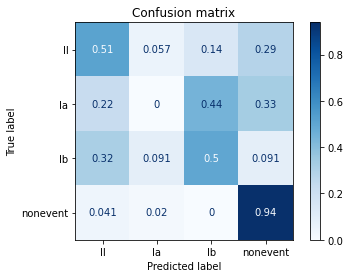

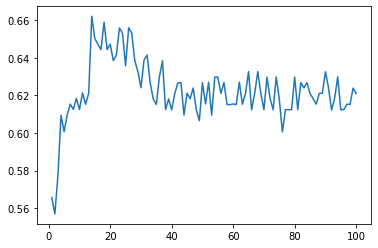

In [225]:
# plotting interediate results
acc = logReg_rfecv.score(x_test, y_test)
print(acc)

conf = plot_confusion_matrix(logReg_rfecv, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix')
plt.show(conf)
plt.show()

plt.plot(
    range(1, len(logReg_rfecv.grid_scores_) + 1),
    logReg_rfecv.grid_scores_,
)

In [226]:
#best features
df_fe = df.loc[: , logReg_rfecv.support_]
x_trainfe, x_testfe, y_trainfe, y_testfe = train_test_split(df_fe, Y, test_size=0.25, random_state=0)
logReg_rfecv.n_features_
df_fe

,CO242.mean,CO2504.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA84.std,SWS.mean,T168.mean,T42.mean,T504.mean,T672.mean,T84.mean
0,385.274688,383.885077,1.127238,99.066615,1.324536,98.885846,1.375835,1.117522,924.863636,-12.662105,-12.201610,-12.808576,-13.016471,-12.422972
1,375.621266,374.674177,1.214009,95.081667,1.265450,95.756835,1.131378,1.283534,851.384615,-8.528346,-8.236107,-8.693842,-8.997430,-8.351043
2,373.961481,373.275062,0.736300,93.532469,0.693400,93.913827,0.774957,0.718172,934.925926,-9.811155,-9.580934,-9.941204,-10.224472,-9.651155
3,379.785872,378.316909,1.201051,99.466147,1.024843,99.637818,1.168720,1.144319,904.942857,-1.049451,-0.669048,-1.221172,-1.535183,-0.829524
4,373.701830,372.910000,14.625643,60.119150,14.369137,60.910915,14.122225,15.260717,923.450980,-1.330589,-1.037435,-1.738455,-2.095641,-1.095864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,380.131355,377.507244,8.418566,56.563013,8.032983,56.304167,7.441727,9.031701,916.859375,16.971159,17.003685,16.620652,16.470062,17.077060
454,382.901742,381.072078,5.722857,78.929675,5.568327,79.537987,5.439746,5.952540,915.250000,17.075372,17.323382,16.608408,16.319361,17.268471
455,392.981111,386.336908,6.147904,80.031184,6.742590,79.822632,7.225602,5.455967,850.539683,13.858028,13.791866,13.636214,13.315270,13.781909
456,381.268591,379.163200,6.026740,77.896242,6.283789,78.177800,6.380528,5.911362,879.032258,14.991524,15.087546,14.667092,14.421092,15.094141


In [227]:
# tuning hyper parameters
search_space = dict(
  {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
  'penalty': ['l1', 'l2', 'elasticnet'],
  'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
  })

tuner = RandomizedSearchCV(logReg, search_space, scoring='accuracy', cv=10, n_jobs=-1)
logReg_param = tuner.fit(x_trainfe, y_trainfe)

C:\Users\Adiel\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.63294118        nan 0.6589916         nan
        nan 0.60647059        nan        nan]
  warnings.warn(


best parameters {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.5}
accuracy 0.6608695652173913
perplecity 2.654731056854226


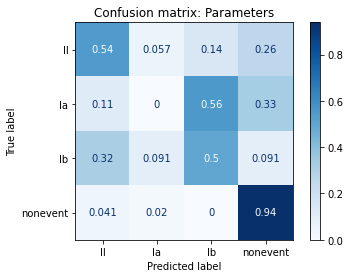

In [228]:
print("best parameters", logReg_param.best_params_)

acc = logReg_param.score(x_testfe, y_testfe)
print("accuracy", acc)


perp = np.exp(np.mean(log_loss(y_testfe, logReg_param.predict_proba(x_testfe))))
print("perplecity", perp)

conf_param = plot_confusion_matrix(logReg_param, x_testfe, y_testfe,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix: Parameters')
plt.show(conf_param)
plt.show()

In [229]:
res_df = pd.DataFrame({
  "predicted probabilities of event": 1 - logReg_param.predict_proba(x_testfe)[:,3],
  "predicted labels" : logReg_param.predict(x_testfe),
  "true labels" : y_testfe
})
res_df

,predicted probabilities of event,predicted labels,true labels
164,0.962875,II,Ib
229,0.157092,nonevent,nonevent
311,0.028964,nonevent,nonevent
221,0.545658,nonevent,II
122,0.730995,II,nonevent
...,...,...,...
252,0.027151,nonevent,nonevent
135,0.261292,nonevent,II
7,0.943682,Ib,Ib
246,0.010875,nonevent,nonevent


In [230]:
#false cases
res_df[res_df["predicted labels"] != res_df["true labels"]]

,predicted probabilities of event,predicted labels,true labels
164,0.962875,II,Ib
221,0.545658,nonevent,II
122,0.730995,II,nonevent
309,0.814206,Ib,II
113,0.991537,Ib,II
213,0.983552,Ib,Ia
339,0.657108,II,Ib
328,0.815439,II,Ib
90,0.276416,nonevent,II
417,0.514069,nonevent,II


In [236]:
#binary acc
df_acc = pd.DataFrame()
df_acc['pred'] = res_df['predicted labels'].apply(lambda x: 'nonevent' if x == 'nonevent' else 'event')
df_acc['true'] = res_df['true labels'].apply(lambda x: 'nonevent' if x == 'nonevent' else 'event')
bin_acc = 1 - len(df_acc[df_acc['pred'] != df_acc['true']]) / len(df_acc)
print("binary acc", bin_acc)

binary acc 0.8521739130434782
